In [9]:
from exm.io.io import nd2ToVol
from exm.io.io import writeH5
from exm.io.io import saveGif
from exm.config.utils import load_cfg
from exm.align.build import alignBuild

import os
import tqdm
import h5py
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# fov 90

## set paths, load vols, compute otsu, perform default alignment w/ otsu mask on fixed vol

In [2]:
fix_path = '/mp/nas2/jlove/alignment/zebrafish/20220801/code0/90.h5'
mov_path = '/mp/nas2/ruihan/20220801_zebrafish/20220803_Code3/Channel405 SD_Seq0004.nd2'

In [3]:
fix = np.asarray(h5py.File(fix_path)['main'])
mov = nd2ToVol(mov_path, 90)

In [4]:
cfg = load_cfg()
align = alignBuild(cfg)
align.buildSitkTile()

In [5]:
fix_mask = align.computeOtsuMask(fix)

In [8]:
tform = align.computeTransformMap(fix, mov, mask_fix = fix_mask.astype('uint8'))
result = align.warpVolume(mov,tform)

In [ ]:
# bad didnt work
saveGif(fix[0,:,:], result[0,:,:], 'tmp.gif')

## try sift flann

In [12]:
fix_slice = fix[0,:,:]
dists=[]
for z in mov[50:120,:,:]:
    dist = align.computeMinFlann(fix_slice,z)
    dists.append(dist)

In [16]:
dist_mat = np.asarray([list(dist) for dist in dists])

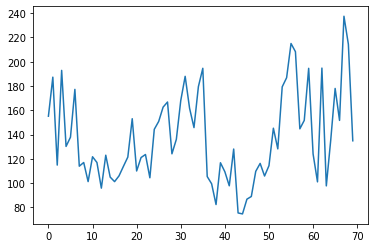

In [17]:
plt.plot(dist_mat[:,1])

In [21]:
# this has a wrapper in sitkTile, was just buggy bc of spelling error should be good now
min_sorted = np.sort(dist_mat[:,1])
        
mi_result = {}

for row, min_val in enumerate(min_sorted[:5]):

    z_ind = np.argwhere(dist_mat[:,1] == min_val)[0][0]+50
    mov_slice = mov[z_ind,:,:]

    mi = align.mutualIinformation(fix_slice,mov_slice)
    mi_result[z_ind] = mi

max_mi_ind = max(mi_result, key=mi_result.get)
max_mi = max(mi_result.values())

In [23]:
max_mi_ind

96

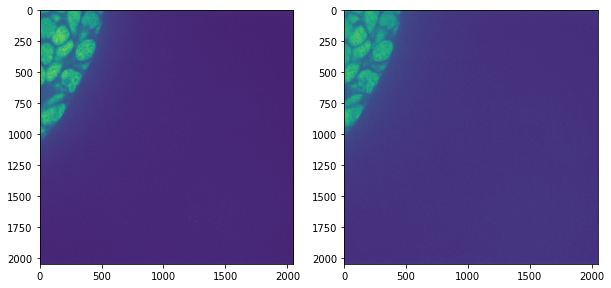

In [24]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].imshow(fix[0,:,:])
ax[1].imshow(mov[max_mi_ind,:,:])

In [26]:
ROI_min_fix = [0,0,0]
ROI_max_fix = [mov.shape[0]-max_mi_ind,2048,2048]

ROI_min_mov = [max_mi_ind,0,0]
ROI_max_mov = [mov.shape[0],2048,2048]

tform, result = align.localToGlobalTform(fix, mov,
                                        ROI_min_fix,
                                        ROI_max_fix,
                                        ROI_min_mov,
                                        ROI_max_mov, mask_fix=fix_mask[:mov.shape[0]-max_mi_ind].astype(np.uint8))

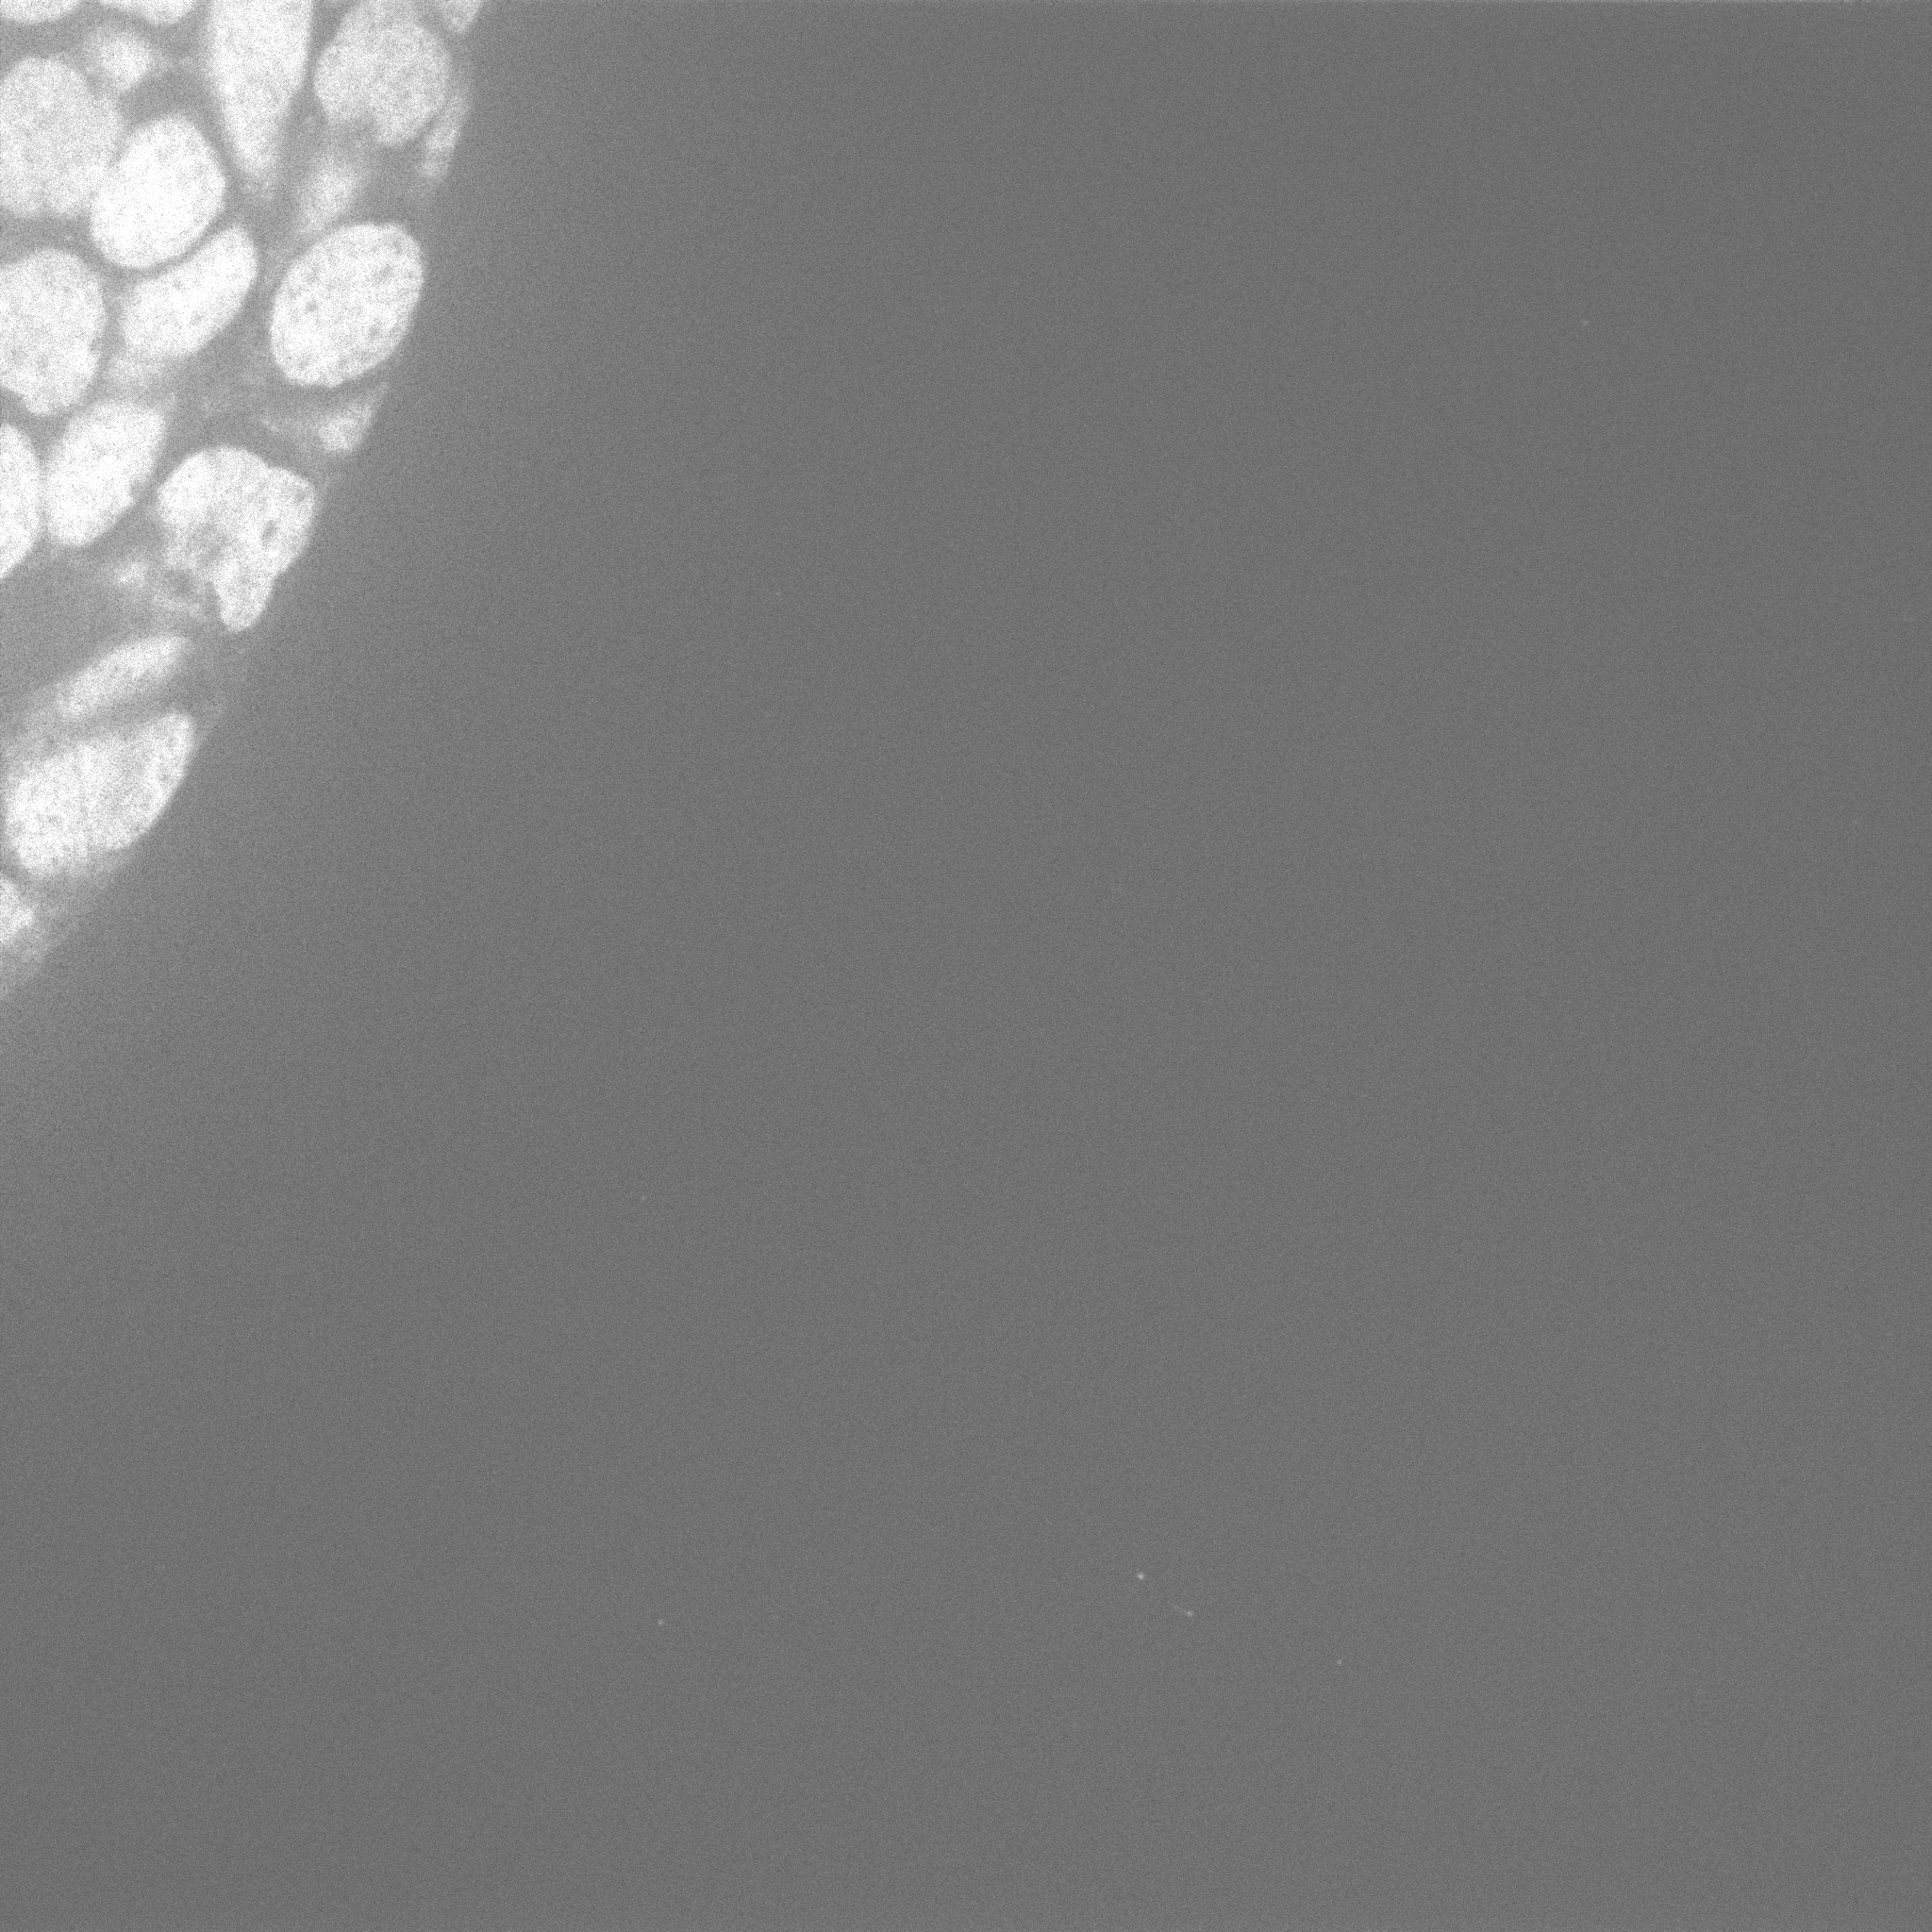

In [27]:
# bad didnt work
saveGif(fix[0,:,:], result[0,:,:], 'tmp.gif')

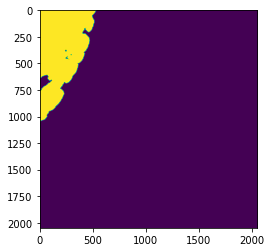

In [28]:
plt.imshow(fix_mask[0,:,:])